In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
df = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0)
df_j = pd.read_csv('data/lab42_cleaned_jan_data.csv', index_col=0)


In [11]:
df.head()

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,occupation,usage,recruitment
1,NaN,NaN,NaN,NaN,NaN,I always feel a bit zen when I am here. It’s q...,"The light in the offices is perfect, as well a...",NaN,Yes,I will be only be participating in the survey
2,NaN,NaN,NaN,NaN,NaN,"Cold, a bit down","Temperature (it’s too cold), lack of light (bu...",NaN,Yes,I will be only be participating in the survey
3,NaN,NaN,NaN,NaN,NaN,Calm,Comfortable temperature and pleasant lighting....,NaN,Yes,I will be only be participating in the survey
4,6th Floor,NaN,NaN,NaN,NaN,"Hungry, a bit cold","Cold, quiet, well lit",NaN,Yes,I would like to participate in a building walk
5,Ground floor,Library learning room,NaN,NaN,NaN,Stressed about my exams but I am happy in this...,Usually it is really nice and comfortably warm...,Yes,Yes,I would like to participate in a building walk


In [16]:
df_j.columns

Index(['floor', 'ground-floor', '1-floor', '2-floor', '3-floor', 'emotion',
       'comfort', 'space usage', 'occupation', 'usage'],
      dtype='object')

# Combine Jans Dataset with Shrutis

In [23]:
df = pd.concat([df.drop(columns=['occupation', 'usage', 'recruitment']),
                df_j.drop(columns=['space usage', 'occupation', 'usage']) ])

# Grouping by Shared vs Individual Space

'Unsure': Unsure

## Group
'Round tables by the three plants (across wooden staircase)'
'Next to the lockers'
'Study corner next to the plant wall'
'Yellow/white chairs & tables (besides the wooden staircase)'
'Tables on the landing (with wooden floor) accessible by the black staircase'
'Green group study tables (between a row of plants and railing)'
'Group tables by the stairs'
'Open lounge area'
'Near the printer'
'Round tables by the coffee machine'

## Individual
'Library learning room'
'Green chairs by the entrance'
'Partly covered green chairs (along glass wall)'

In [24]:
group = ['Round tables by the three plants (across wooden staircase)',
                        'Next to the lockers',
                        'Study corner next to the plant wall',
                        'Yellow/white chairs & tables (besides the wooden staircase)',
                        'Tables on the landing (with wooden floor) accessible by the black staircase',
                        'Green group study tables (between a row of plants and railing)',
                        'Group tables by the stairs',
                        'Open lounge area',
                        'Near the printer',
                        'Round tables by the coffee machine']

individual =  ['Library learning room',
                             'Green chairs by the entrance',
                             'Partly covered green chairs (along glass wall)']

unsure = ["Unsure"]

def assign_types_to_spaces(space):
    if space in group:
        return "group"
    if space in individual:
        return "individual"
    if space in unsure:
        return "unsure"
    
def merge_spaces(df):
    df["space-type"] = df["space-ground-floor"] + df["space-1-floor"] + df["space-2-floor"] + df["space-3-floor"]
    df = df.drop(columns =["space-ground-floor", "space-1-floor", "space-2-floor", "space-3-floor"])
    
    return df


def create_group_solo_space_labels(df):
    spaces = ["ground-floor", "1-floor", "2-floor", "3-floor"]
    
    for space in spaces:
        df["space-" + space] = df[space].apply(lambda space: assign_types_to_spaces(space)).fillna("")
    
    return df


df = create_group_solo_space_labels(df)
df = merge_spaces(df)

In [52]:
df.floor.value_counts()

1st Floor       134
Ground floor     66
2nd Floor        16
3rd Floor        14
6th Floor         7
Name: floor, dtype: int64

# Overview of Respondents

In [5]:
df.occupation.value_counts()

Yes    114
No      11
Name: occupation, dtype: int64

In [6]:
df.recruitment.value_counts()

I will be only be participating in the survey     99
I would like to participate in a building walk    26
Name: recruitment, dtype: int64

# Students Across the Floors

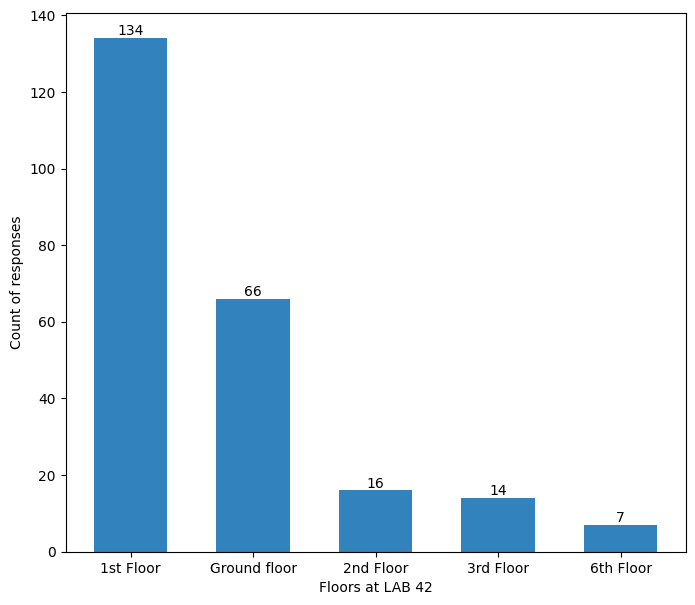

In [81]:
fig, ax = plt.subplots()
data = df.floor.value_counts()
data = pd.DataFrame(data).reset_index().rename(columns={"index": "Floor", "floor": "Count of Responses"})
width = 0.6

p=ax.bar(data.Floor, data["Count of Responses"], width, color = "#3182bd")
ax.bar_label(p, label_type='edge')
plt.ylabel("Count of responses")
plt.xlabel("Floors at LAB 42")
fig.set_size_inches(8, 7)
plt.savefig('plots/floors-responses.jpg', dpi=300, bbox_inches="tight")

### Grouped by Floor and Space Type

In [75]:
test = df.groupby(['floor', 'space-type'])['ground-floor', '1-floor', '2-floor', '3-floor'].count()
test['counts'] = test['ground-floor'] + test['1-floor'] + test['2-floor'] + test['3-floor']
test = test['counts'].reset_index().drop([0,4,10])

/var/folders/37/5q1f19yn0f19tsfhqd_3fsnh0000gn/T/ipykernel_28926/2757327659.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test = df.groupby(['floor', 'space-type'])['ground-floor', '1-floor', '2-floor', '3-floor'].count()


<Figure size 800x700 with 0 Axes>

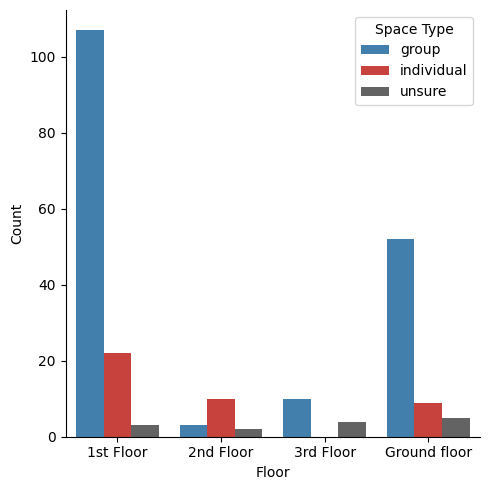

In [86]:
plt.figure(figsize=(8, 7))
custom_palette = {'group': '#3182bd',
                  'individual': '#de2d26',
                  'unsure': '#636363'}

plot = sns.catplot(x='floor',
                   y='counts',
                   hue='space-type',
                   kind='bar',
                   data=test,
                   legend=False,
                   palette=custom_palette
                  )

plt.xlabel('Floor')
plt.ylabel('Count')

ax = plot.ax
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], labels[0:3], title='Space Type')
plt.tight_layout()
plt.savefig('plots/floors-space-type.jpg', dpi=300, bbox_inches="tight")

In [37]:
df[df['floor'] == '6th Floor']

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,space-type
4,6th Floor,NaN,NaN,NaN,NaN,"Hungry, a bit cold","Cold, quiet, well lit",
18,6th Floor,NaN,NaN,NaN,NaN,NaN,NaN,
37,6th Floor,NaN,NaN,NaN,NaN,"Tired, busy",Noisy (poor sound insulation between rooms),
38,6th Floor,NaN,NaN,NaN,NaN,Peaceful,Default brightness is a little bright,
41,6th Floor,NaN,NaN,NaN,NaN,Ok,Ok,
75,6th Floor,NaN,NaN,NaN,NaN,"Convenient, and calm sometime",I am quite comfortable with the overall enviro...,
123,6th Floor,NaN,NaN,NaN,NaN,Calm,8/10,


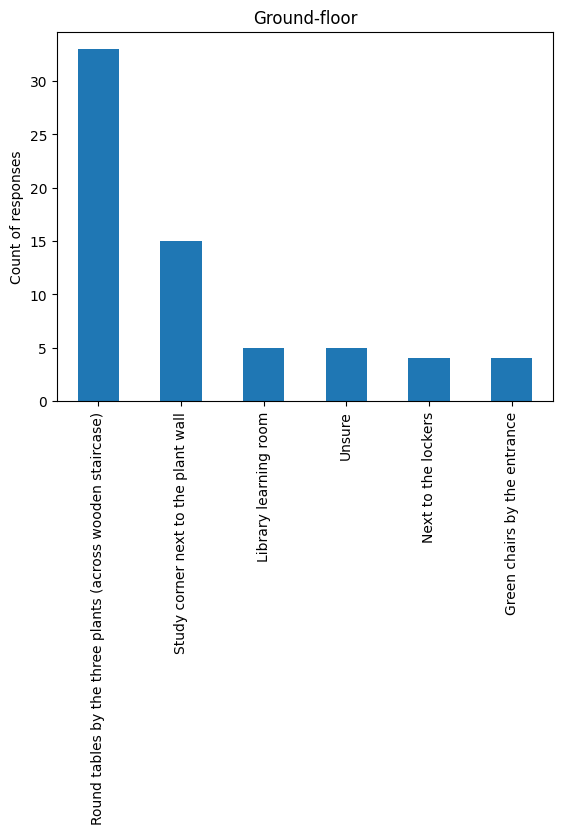

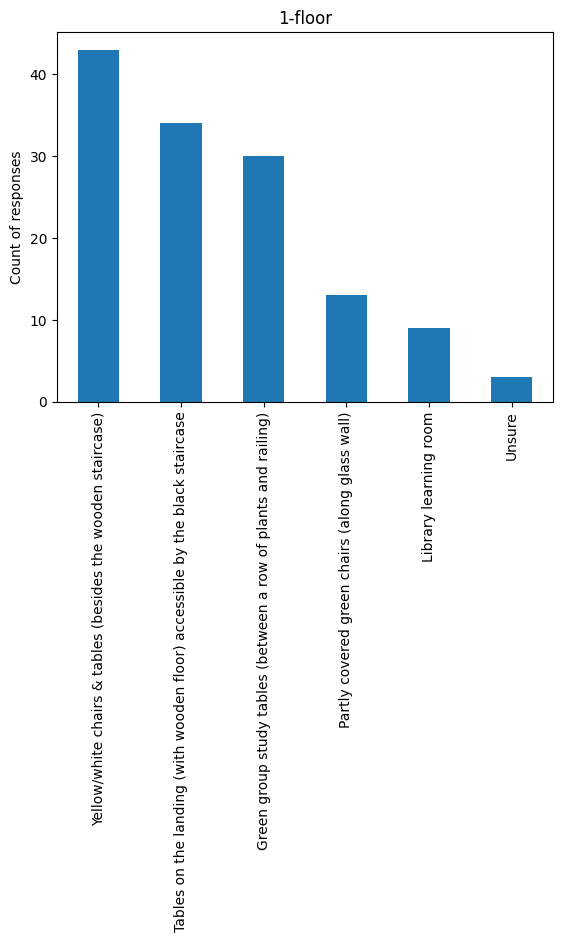

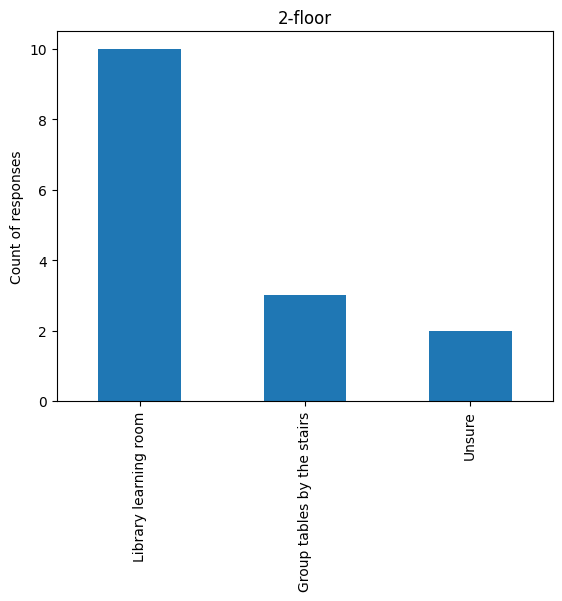

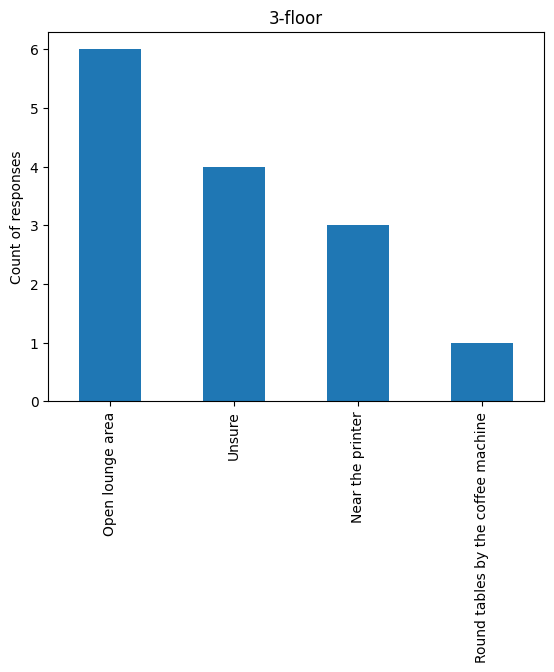

In [39]:
def plot_responses_rooms(floor):
    # ax = plt.subplot(2, 2, n + 1)
    p = df[floor].value_counts().plot.bar()
    # ax.bar_label(p, label_type='edge')
    plt.ylabel("Count of responses")
    plt.title(floor.capitalize())

# plt.figure(figsize=(15, 12))
# plt.subplots_adjust(hspace=3)
floors = ['ground-floor', '1-floor', '2-floor', '3-floor']

for floor in floors:
    fig, ax = plt.subplots()
    plot_responses_rooms(floor)
    plt.savefig('plots/' + floor + '.jpg',
            dpi=300, bbox_inches='tight')

# Emotions

In [9]:
df_emo = df.emotion.dropna()
df_emo = df_emo.apply(lambda x: x.replace('’', ''))

### Tokenise

In [10]:
import string

def apply_token(row):
    stop_words = set(stopwords.words("english"))
    words_in_sent = word_tokenize(row)

    filtered_list = []
    
    for word in words_in_sent:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list

def cleanup(df_emo):
    combo_emo = []
    for row in df_emo:
        combo_emo.append(row)
    
    combo_emo = list(np.concatenate(combo_emo).flat)
    combo_emo = list(filter(lambda token: token not in string.punctuation,
                            combo_emo))
    combo_emo = [x.lower() for x in combo_emo]
    
    return combo_emo

In [11]:
df_emo = df_emo.apply(apply_token)
combo_emo_list = cleanup(df_emo)

In [12]:
def frequency_distribution(lst, label):
    top_n = FreqDist(lst).most_common(20)
    frequency_distribution = pd.Series(dict(top_n))

    sns.set_theme(style="ticks")
    sns.barplot(y=frequency_distribution.index,
                x=frequency_distribution.values,
                palette = 'hls',
                saturation = 8)
    plt.xlabel("Count of responses")
    plt.ylabel("Most frequently occuring responses")
    plt.gcf().set_size_inches(5,7)
    # plt.xlim(0,20)

    plt.savefig('plots/' + label + '-freq-dist.jpg',
            dpi=300, bbox_inches='tight')

In [15]:
frequency_distribution = FreqDist(combo_emo_list)

In [16]:
frequency_distribution.most_common(20)
frequency_distribution(combo_emo_list, 'emo')

TypeError: 'FreqDist' object is not callable

calm (19), bit (6), nice (5), feel (4), quiet (4), neutral (4), relaxed (4), focused (4), noisy (3), cold (3), stressed (3), happy (3), motivated (3), peaceful (3), tired (3), good (3), study (3), building (3)

Interesting to note that words associated with emotion questions also included some words about comfort such as `cold` and `noisy`. Overall, we see that words associated with emotions are a mix of emotions, moods, sentiments, that are also typically associated with learning (`stressed`, `focused`, `motivated`)

### Lemmatisation

In [18]:
def lemmatiser(labels):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in labels]
    return lemmatized_words

def check_collocations(lst):
    return nltk.Text(lst).collocations()
    
def find_collocations(df_emo):
    lem_emo = df_emo.apply(lemmatiser)
    combined_emos = list(np.concatenate(lem_emo.to_list()).flat)
    return check_collocations(combined_emos)

In [19]:
find_collocations(df_emo)

feeling fine; ground floor; natural light; feel like; day studying;
Nice quiet; feel bit; feel cozy; calm comfortable; study Calm; calm
Calm


study calm were the most frequently occuring pair of words (collocations) in the list of emotions.

# Comfort

In [ ]:
df_comfort = df.comfort.dropna()
df_comfort = df_comfort.apply(lambda x: x.replace('’', ''))

### Tokenise

In [ ]:
df_comfort = df_comfort.apply(apply_token)
combo_comfort_list = cleanup(df_comfort)

In [ ]:
combo_comfort_list = [word for word in combo_comfort_list if word != "'s"]

In [ ]:
frequency_distribution = FreqDist(combo_comfort_list)
frequency_distribution.most_common(20)

In [ ]:
frequency_distribution(combo_comfort_list, 'comfort')

'comfortable' (23), 'light'(12), 'cold' (10), 'good' (10), 'noise' (9), 'temperature' (8), 'air' (8), 'nice' (8), 'room' (7), ('pretty', 7), ('space', 5), ('quality', 5), ('window', 5), ('fine', 5), ('like', 5), ('noisy', 5), ('little', 5), ('well', 4), ('lighting', 4), ('warm', 4), ('lot', 4), ('make', 4), ('feel', 4), ('blinds', 4), ('dark', 4), ('natural', 4), ('ok', 4), ('perfect', 3)

Most focus on light and temperature followed by noise. People also noted overall space and comfort as a whole. 

### Lemmatisation

In [ ]:
find_collocations(df_comfort)

Air quality was the most ferquently occuring word.

In [ ]:
from collections import Counter
combo_comfort_cloud=Counter(combo_comfort_list)

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate_from_frequencies(combo_comfort_cloud)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# Sentiment Analysis

In [17]:
def sentiment_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-polarity'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x)))
    df = pd.concat([df, df[label + '-polarity'].apply(pd.Series)], axis=1)
    df[label + '-sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

    print("Most positive emotion statement: ", df.loc[df['compound'].idxmax()].values)
    print("\n")
    print("Most negative emotion statement: ", df.loc[df['compound'].idxmin()].values)
    
    return df 

In [22]:
def plot_sentiment_analysis(df, label):
    sns.countplot(y=label+'-sentiment', 
                  data=df,
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Sentiment for " + label + " Text")
    plt.xlabel("Count")
    # plt.xlim(0,45)
    plt.savefig('plots/' + label + '-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')
    
    plt.clf()
    
    sns.boxplot(x='floor', y='compound', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/' + label + '-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    

def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [18]:
df = df.dropna(subset=['emotion'], how='all')
df_sent_emo = sentiment_analysis(df, 'emotion')
df_sent_emo.to_csv('data/sentiment_data/students-emo-lab42.csv')
plot_sentiment_analysis(df_sent_emo, 'emotion')
plot_sentiment_analysis_spaces(df_sent_emo, "emotion")

Most positive emotion statement:  ['1st Floor' nan 'Partly covered green chairs (along glass wall)' nan nan
 'It is open, and this does not necessarily make me relaxed, it feels like i am standing in a hall/pass way, not really a study area. I like that it is naar window, where you can see people walking and going somewhere. I like it is fading rhe sunny side, makes me happy'
 'It is a little too noisey, and too spacious, it smells like building, temperature is comfortable, like the natural light '
 'Yes' 'Yes' 'I will be only be participating in the survey' 'individual'
 {'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.9451} 0.0 0.709
 0.291 0.9451 'positive']


Most negative emotion statement:  ['1st Floor' nan
 'Green group study tables (between a row of plants and railing)' nan nan
 "Normal. Just sad about the fact that we can't use the other floors. (3, 4, 5, 6)"
 nan nan nan nan 'group'
 {'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.4767} 0.162 0.838
 0.0 -0.4767 

In [19]:
df_sent_emo

,floor,ground-floor,1-floor,2-floor,3-floor,emotion,comfort,occupation,usage,recruitment,space-type,emotion-polarity,neg,neu,pos,compound,emotion-sentiment
1,NaN,NaN,NaN,NaN,NaN,I always feel a bit zen when I am here. It’s q...,"The light in the offices is perfect, as well a...",NaN,Yes,I will be only be participating in the survey,,"{'neg': 0.098, 'neu': 0.865, 'pos': 0.037, 'co...",0.098,0.865,0.037,-0.2732,negative
2,NaN,NaN,NaN,NaN,NaN,"Cold, a bit down","Temperature (it’s too cold), lack of light (bu...",NaN,Yes,I will be only be participating in the survey,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
3,NaN,NaN,NaN,NaN,NaN,Calm,Comfortable temperature and pleasant lighting....,NaN,Yes,I will be only be participating in the survey,,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.000,0.000,1.000,0.3182,positive
4,6th Floor,NaN,NaN,NaN,NaN,"Hungry, a bit cold","Cold, quiet, well lit",NaN,Yes,I would like to participate in a building walk,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral
5,Ground floor,Library learning room,NaN,NaN,NaN,Stressed about my exams but I am happy in this...,Usually it is really nice and comfortably warm...,Yes,Yes,I would like to participate in a building walk,individual,"{'neg': 0.06, 'neu': 0.421, 'pos': 0.519, 'com...",0.060,0.421,0.519,0.9337,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,1st Floor,NaN,Green group study tables (between a row of pla...,NaN,NaN,"I’m a little cold, but otherwise calm and comf...","There is a nice background noise, and natural ...",Yes,Yes,I will be only be participating in the survey,group,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.000,0.448,0.552,0.8126,positive
149,1st Floor,NaN,Yellow/white chairs & tables (besides the wood...,NaN,NaN,Relaxed and focused,"Temperature okay, I can hear the people around...",Yes,Yes,I will be only be participating in the survey,group,"{'neg': 0.0, 'neu': 0.147, 'pos': 0.853, 'comp...",0.000,0.147,0.853,0.7003,positive
150,Ground floor,Green chairs by the entrance,NaN,NaN,NaN,Pretty relaxed,Sure,Yes,NaN,NaN,individual,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.000,0.000,1.000,0.7506,positive
152,1st Floor,NaN,Green group study tables (between a row of pla...,NaN,NaN,Comfortable,Color,Yes,Yes,NaN,group,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.000,0.000,1.000,0.5106,positive


### Emotion: `Calm`

In [ ]:
df_sent_emo[['floor','emotion', 'emotion-sentiment']][df_sent_emo['emotion'].str.contains("calm")==True]

In [ ]:
df_sent_emo['emotion'][df_sent_emo['emotion'].str.contains("relaxed")==True]:
    print(row)

## Comfort: `light`

Most positive emotion statement:  ['1st Floor' nan 'Partly covered green chairs (along glass wall)' nan nan
 'Calm. Motivated. '
 "I love sitting by the window to have more (natural) light. it's a bit dark otherwise and air quality could be better, but I'm allergic and therefore more sensitive. it's a bit too warm for my liking, but not necessarily unpleasant. I love the colours. Green always has a calming effect on me"
 'Yes' 'Yes' 'I will be only be participating in the survey' 'individual'
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6486}
 {'neg': 0.042, 'neu': 0.607, 'pos': 0.351, 'compound': 0.9654} 0.042
 0.607 0.351 0.9654 'positive']


Most negative emotion statement:  ['Ground floor' 'Study corner next to the plant wall' nan nan nan
 'Neutral'
 'My chair makes my back hurt and I the lack chalkboards gives me existential pain. 7/10'
 'Yes' 'Yes' 'I will be only be participating in the survey' 'group'
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 {'neg': 0.429,

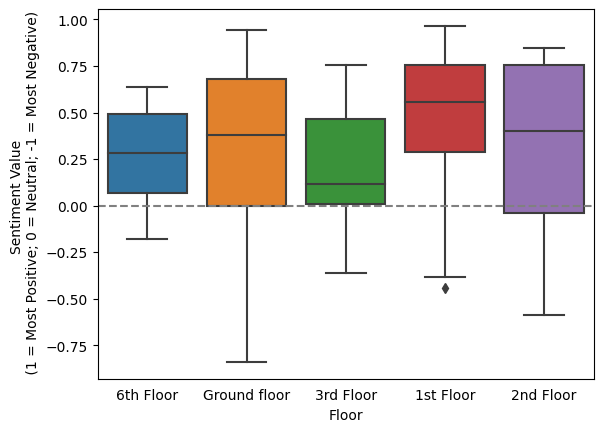

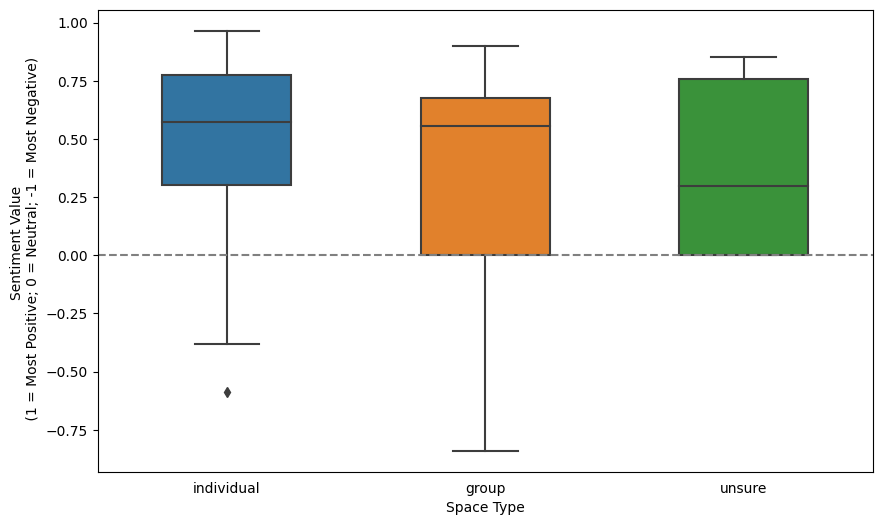

In [26]:
df = df.dropna(subset=['comfort'], how='all')
df_sent_comfort = sentiment_analysis(df, 'comfort')
df_sent_comfort.to_csv('data/sentiment_data/students-comfort-lab42.csv')
plot_sentiment_analysis(df_sent_comfort, 'comfort')
plot_sentiment_analysis_spaces(df_sent_comfort, "comfort")